## Prerequisites

In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file, split_ids
from utils.preprocessing import create_batch_sequences
from models.models import build_model
from models.losses import MyWeightedBinaryCrossentropy, MyWeightedMeanSquaredError
from utils.evaluate import compare_events
from scipy.signal import find_peaks
np.random.seed(123)

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

## Get data

In [2]:
# Set root directory
ROOT_DIR = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"

# Split subjects into a train, validation, and test set
train_ids, val_ids, test_ids = split_ids(ROOT_DIR, by=["gender", "participant_type"])

In [3]:
# User settings
TRACKED_POINTS = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
INCL_MAGN = False
NORMALIZE = True

In [4]:
# Get datasets
ds_train = load_dataset(ROOT_DIR, sub_ids=train_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_val = load_dataset(ROOT_DIR, sub_ids=val_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_test = load_dataset(ROOT_DIR, sub_ids=test_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)

In [5]:
# Create batches of sequences for training and validation
WIN_LEN = 400
STEP_LEN = 200
train_data, train_targets, ds_train_batches = create_batch_sequences(ds_train, win_len=WIN_LEN, step_len=STEP_LEN)
val_data, val_targets, ds_val_batches = create_batch_sequences(ds_val, win_len=WIN_LEN, step_len=STEP_LEN)

## Build model

In [6]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [7]:
NB_FILTERS = 16
KERNEL_SIZE = 5
DILATIONS = [1, 2, 4]
PADDING = "same"

In [8]:
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

In [9]:
kwargs = {
    "nb_filters": NB_FILTERS,
    "kernel_size": KERNEL_SIZE,
    "dilations": DILATIONS,
    "padding": PADDING,
}

In [10]:
INPUT_DIM = train_data.shape[-1]
CLASS_NAMES = list(train_targets.keys())
# LOSS_FN = keras.losses.MeanSquaredError()
# LOSS_FN = MyWeightedMeanSquaredError(0.01)

In [11]:
model = build_model(
    input_dim=INPUT_DIM, 
    class_names=CLASS_NAMES, 
    loss_fn=MyWeightedMeanSquaredError(1/300), 
    **kwargs
)
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 16)     7472        ['inputs[0][0]']                 
                                                                                                  
 initial_contact (Dense)        (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                                  
 final_contact (Dense)          (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                          

In [12]:
MAX_EPOCHS = 150

In [14]:
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train targets: {train_targets.shape}")
print(f"Shape of validation data: {val_data.shape}")

Shape of train data: (3366, 400, 6)


AttributeError: 'dict' object has no attribute 'shape'

In [15]:
history = model.fit(
    x=train_data, 
    y=train_targets, 
    batch_size=16, 
    epochs=MAX_EPOCHS, 
    validation_data=(val_data, val_targets),
    shuffle=True,
    callbacks=CALLBACKS,
    verbose=1
)

Epoch 1/150
211/211 [==============================] - 6s 10ms/step - loss: 0.0068 - initial_contact_loss: 0.0025 - final_contact_loss: 0.0043 - val_loss: 0.0017 - val_initial_contact_loss: 9.0549e-04 - val_final_contact_loss: 7.6094e-04
Epoch 2/150
211/211 [==============================] - 2s 7ms/step - loss: 9.7672e-04 - initial_contact_loss: 4.8375e-04 - final_contact_loss: 4.9298e-04 - val_loss: 9.9659e-04 - val_initial_contact_loss: 4.8807e-04 - val_final_contact_loss: 5.0852e-04
Epoch 3/150
211/211 [==============================] - 2s 7ms/step - loss: 7.6321e-04 - initial_contact_loss: 3.9009e-04 - final_contact_loss: 3.7312e-04 - val_loss: 8.9132e-04 - val_initial_contact_loss: 4.3014e-04 - val_final_contact_loss: 4.6118e-04
Epoch 4/150
211/211 [==============================] - 2s 7ms/step - loss: 6.8111e-04 - initial_contact_loss: 3.5462e-04 - final_contact_loss: 3.2649e-04 - val_loss: 8.2961e-04 - val_initial_contact_loss: 4.0964e-04 - val_final_contact_loss: 4.1997e-04
Epo

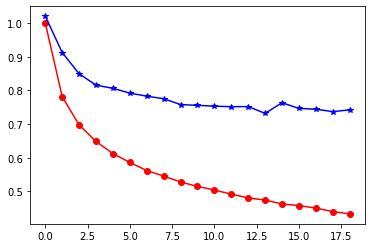

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot([history.history["loss"][i]/history.history["loss"][1] for i in range(1, len(history.history["loss"]))], 'ro-', label='training')
ax.plot([history.history["val_loss"][i]/history.history["loss"][1] for i in range(1, len(history.history["loss"]))], 'b*-', label="validation")
plt.show()

### Evaluate on test set

In [25]:
np.argwhere(train_targets['initial_contact'][0][:,0]==1)[:,0]
np.argwhere(train_targets['final_contact'][0][:,0]==1)[:,0]

array([ 93, 315])

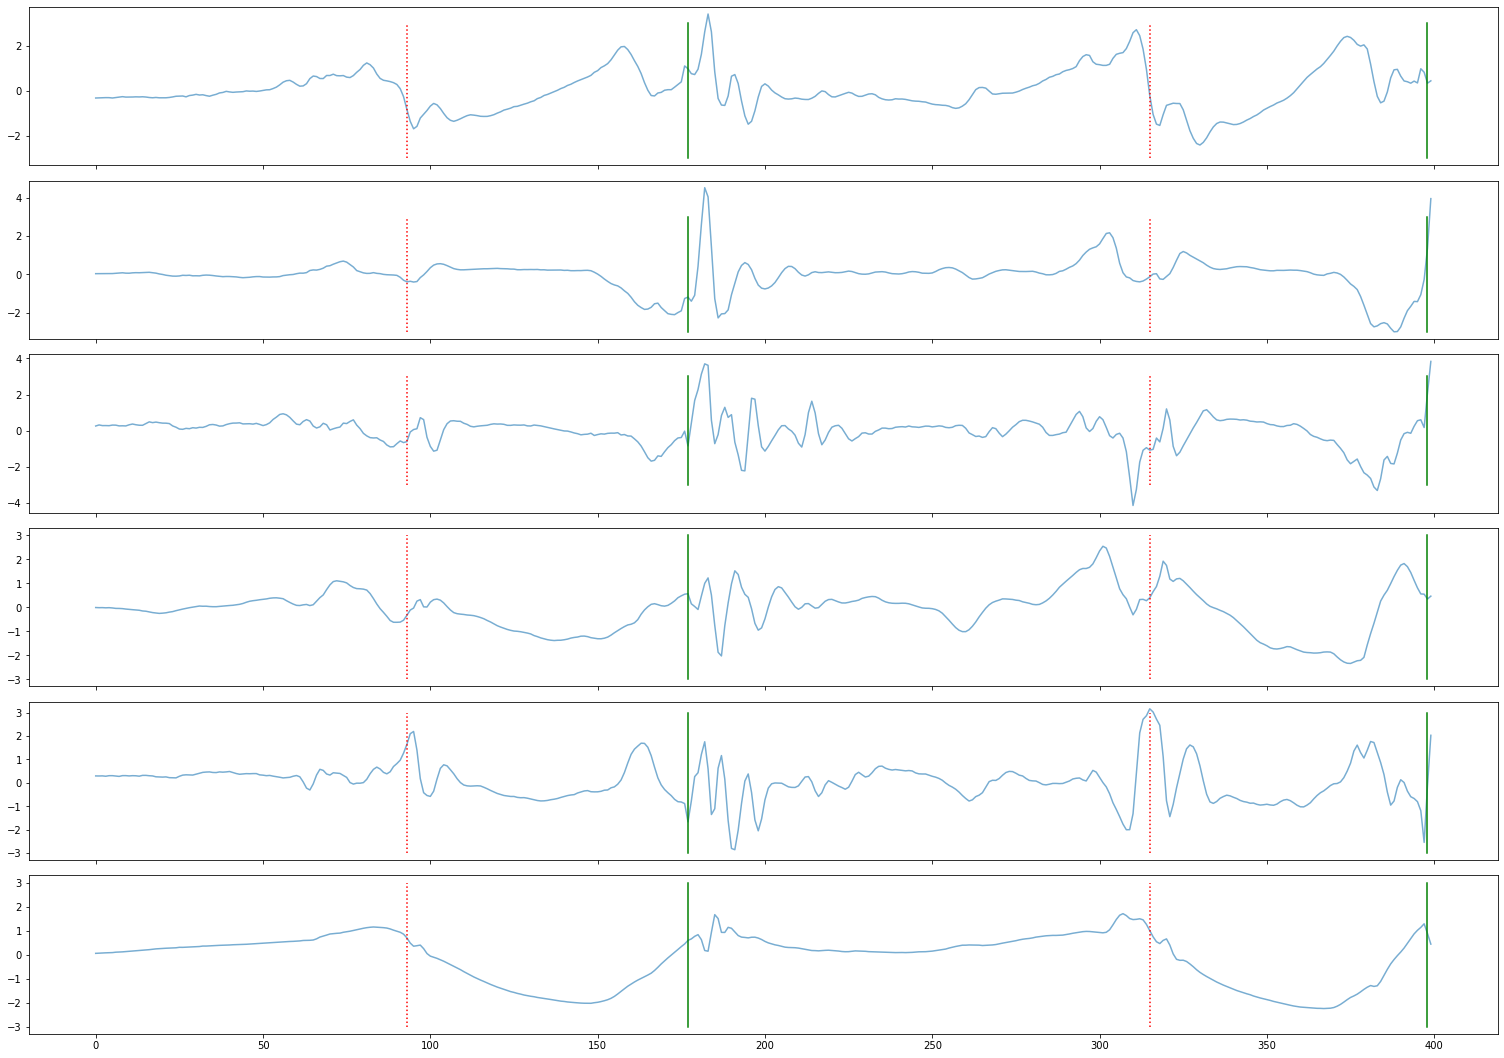

In [27]:
# Delete after use
ix_instance = 0
fig, axs = plt.subplots(6, 1, figsize=(21, 14.8), sharex=True)
for ix_chan in range(train_data.shape[-1]):
    axs[ix_chan].plot(train_data[ix_instance][:,ix_chan], ls='-', alpha=0.6)
    for ix_event in np.argwhere(train_targets['initial_contact'][0][:,0]==1)[:,0]:
        axs[ix_chan].plot([ix_event, ix_event], [-3, 3], ls='-', color='green')
    for ix_event in np.argwhere(train_targets['final_contact'][0][:,0]==1)[:,0]:
        axs[ix_chan].plot([ix_event, ix_event], [-3, 3], ls=':', color='red')
plt.tight_layout()
plt.savefig("/home/robbin/Desktop/input_signals.png", dpi=300)
plt.show()

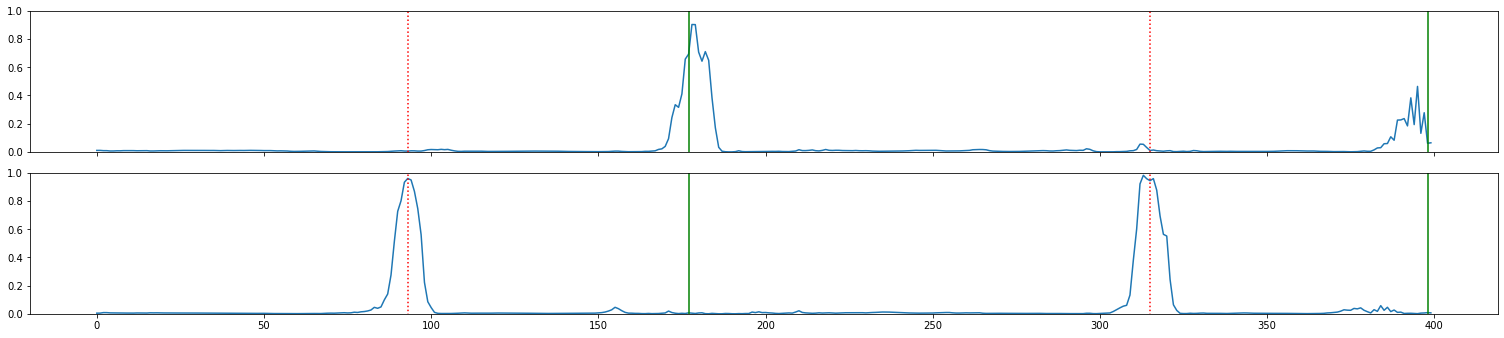

In [36]:
# Delete after use
ix_instance = 0
train_preds = model.predict(np.expand_dims(train_data[ix_instance, :, :], axis=0))
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(21, 4.8))
for ix_chan in range(len(train_preds)):
    axs[ix_chan].plot(train_preds[ix_chan][0][:,0])
    for ix_event in np.argwhere(train_targets['initial_contact'][0][:,0]==1)[:,0]:
        axs[ix_chan].plot([ix_event, ix_event], [-3, 3], ls='-', color='green')
    for ix_event in np.argwhere(train_targets['final_contact'][0][:,0]==1)[:,0]:
        axs[ix_chan].plot([ix_event, ix_event], [-3, 3], ls=':', color='red')
    axs[ix_chan].set_ylim((0, 1))
plt.tight_layout()
plt.savefig("/home/robbin/Desktop/output_signals.png", dpi=300)
plt.show()

In [17]:
for ix_instance in range(len(ds_test)):
    ds_test[ix_instance]['predictions'] = model.predict(np.expand_dims(ds_test[ix_instance]['data'], axis=0))

In [16]:
df_out = {
    'sub_id': [],
    'filename_prefix': [],
    'tracked_point': [],
    'event_type': [],
    'ix_ref': [],
    'ix_pred': []
}
for ix_instance in range(len(ds_test)):
    # Filename prefix
    # print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
    
    # Initial contacts
    ix_targets_IC = np.argwhere(ds_test[ix_instance]['targets']['initial_contact']==1)[:,0]
    ix_predictions_IC, _ = find_peaks(ds_test[ix_instance]['predictions'][0][0][:,0], height=0.4, distance=200//4)
    targets_2_predictions, predictions_2_targets, _ = compare_events(ix_targets_IC, ix_predictions_IC, thr=25)
    # print(f"{'Map targets to preds':>22s}: {targets_2_predictions}")
    # print(f"{'Index of targets':>22s}: {ix_targets_IC}")
    # print(f"{'Index of preds':>22s}: {ix_predictions_IC}")
    # print(f"{'Map preds to targets':>22s}: {predictions_2_targets}")
    
    # Loop over the target ICs
    for i in range(len(ix_targets_IC)):
        # If this IC maps to a predicted event
        if targets_2_predictions[i] > -999:
            # Add the corresponding prediction to the list
            df_out['ix_pred'].append(ix_predictions_IC[targets_2_predictions[i]])
        else:
            df_out['ix_pred'].append(np.nan)
        df_out['ix_ref'].append(ix_targets_IC[i])
        df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
        df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
        df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
        df_out['event_type'].append('IC')
    # Loop over the remaining predicted ICs
    for i in range(len(ix_predictions_IC)):
        if predictions_2_targets[i] == -999:
            df_out['ix_ref'].append(np.nan)
            df_out['ix_pred'].append(ix_predictions_IC[i])
            df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
            df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
            df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
            df_out['event_type'].append('IC')
    
    # Final contacts
    ix_targets_FC = np.argwhere(ds_test[ix_instance]['targets']['final_contact']==1)[:,0]
    ix_predictions_FC, _ = find_peaks(ds_test[ix_instance]['predictions'][1][0][:,0], height=0.4, distance=200//4)
    targets_2_predictions, predictions_2_targets, _ = compare_events(ix_targets_FC, ix_predictions_FC, thr=25)
    # print(f"{'Map targets to preds':>22s}: {targets_2_predictions}")
    # print(f"{'Index of targets':>22s}: {ix_targets_IC}")
    # print(f"{'Index of preds':>22s}: {ix_predictions_IC}")
    # print(f"{'Map preds to targets':>22s}: {predictions_2_targets}")
    
    # Loop over the target ICs
    for i in range(len(ix_targets_FC)):
        # If this IC maps to a predicted event
        if targets_2_predictions[i] > -999:
            # Add the corresponding prediction to the list
            df_out['ix_pred'].append(ix_predictions_FC[targets_2_predictions[i]])
        else:
            df_out['ix_pred'].append(np.nan)
        df_out['ix_ref'].append(ix_targets_FC[i])
        df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
        df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
        df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
        df_out['event_type'].append('FC')
    # Loop over the remaining predicted ICs
    for i in range(len(ix_predictions_FC)):
        if predictions_2_targets[i] == -999:
            df_out['ix_ref'].append(np.nan)
            df_out['ix_pred'].append(ix_predictions_FC[i])
            df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
            df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
            df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
            df_out['event_type'].append('FC')

6 gait events annotated, but none were detected.
4 gait events annotated, but none were detected.
3 gait events annotated, but none were detected.


In [17]:
df_out = pd.DataFrame(df_out)
df_out

,sub_id,filename_prefix,tracked_point,event_type,ix_ref,ix_pred
0,pp156,sub-pp156_task-walkFast,left_ankle,IC,139.0,139.0
1,pp156,sub-pp156_task-walkFast,left_ankle,IC,329.0,325.0
2,pp156,sub-pp156_task-walkFast,left_ankle,IC,514.0,513.0
3,pp156,sub-pp156_task-walkFast,left_ankle,IC,700.0,691.0
4,pp156,sub-pp156_task-walkFast,left_ankle,IC,882.0,877.0
...,...,...,...,...,...,...
6025,pp033,sub-pp033_task-walkSlow,right_shank,FC,440.0,440.0
6026,pp033,sub-pp033_task-walkSlow,right_shank,FC,768.0,768.0
6027,pp033,sub-pp033_task-walkSlow,right_shank,FC,1113.0,1112.0
6028,pp033,sub-pp033_task-walkSlow,right_shank,FC,1450.0,1451.0


In [18]:
df_out.to_csv('gait_events_v3.tsv', sep='\t')

In [19]:
from utils.plot_utils import plot_predictions

In [39]:
for ix_instance in range(len(ds_test)):
    if "sub-pp044" in ds_test[ix_instance]["filename_prefix"] and "Slow" in ds_test[ix_instance]["filename_prefix"] and "right_ankle" in ds_test[ix_instance]["tracked_point"]:
        print(f"{ix_instance}: {ds_test[ix_instance]['filename_prefix']:s}")

241: sub-pp044_task-walkSlow


sub-pp044_task-walkSlow ... right_ankle


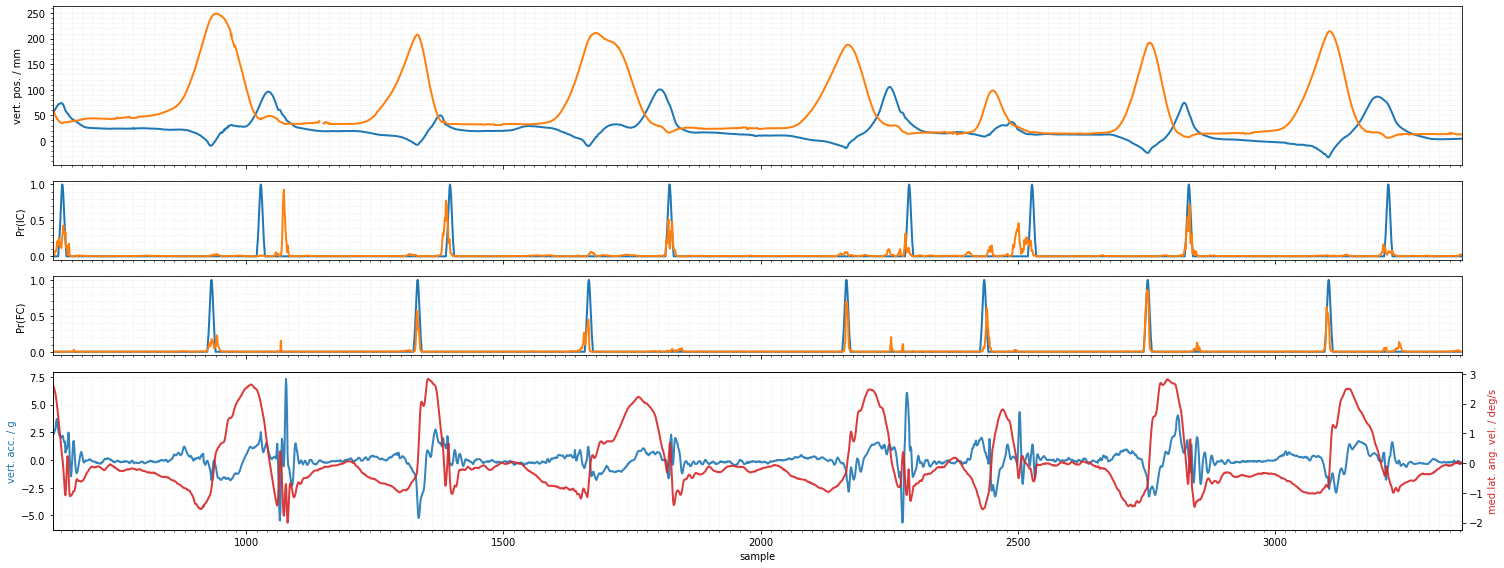

In [40]:
# ix_instance = np.random.choice(len(ds_test), size=1, replace=False)[0]
ix_instance = 241
print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
predictions = model.predict(np.expand_dims(ds_test[ix_instance]["data"], axis=0))
plot_predictions(
    path=ROOT_DIR,
    data=ds_test[ix_instance]["data"],
    targets=ds_test[ix_instance]["targets"],
    predictions=predictions,
    filename_prefix=ds_test[ix_instance]["filename_prefix"],
    tracked_point=ds_test[ix_instance]["tracked_point"]
)

In [41]:
ipks, _ = find_peaks(ds_test[ix_instance]["predictions"][0][0][:,0], height=0.4, distance=200//4)
print(ipks)
print(np.argwhere(ds_test[ix_instance]['targets']['initial_contact']==1)[:,0])

[  21  450  765 1198 1879 2211]
[  19  405  773 1200 1666 1905 2210 2598]


In [23]:
from scipy.signal import peak_prominences
prominences, _, _ = peak_prominences(ds_test[ix_instance]["predictions"][1][0][:,0], ipks)
print(prominences)

[0.70878518 0.66574173 0.79787489 0.85614026 0.88248518 0.70281982
 0.78263299]


In [42]:
# model.save("/home/robbin/Projects/my-gait-events-tcn/models/trained_model")

INFO:tensorflow:Assets written to: /home/robbin/Projects/my-gait-events-tcn/models/trained_model/assets


INFO:tensorflow:Assets written to: /home/robbin/Projects/my-gait-events-tcn/models/trained_model/assets


In [43]:
type(ds_test)

list

In [45]:
import _pickle as cp
with open(os.path.join(".", "test_set_and_predictions.pkl"), 'wb') as outfile:
    cp.dump(ds_test, outfile)